# 10. DNA methylation analysis using bisulfite sequencing data
## 10.4 データフィルタリング & 探索的解析
ここでは、`methylKit` パッケージを利用して解析します。

テキストの解説は、ほぼ methylKit パッケージのドキュメントから抜粋した内容になるので、本家のドキュメントも参照することをおすすめします。  
<https://bioconductor.org/packages/release/bioc/vignettes/methylKit/inst/doc/methylKit.html>

### 10.4.1 methylation call ファイルを読み込む
```
##         chrBase   chr    base strand coverage freqC  freqT
## 1 chr21.9764539 chr21 9764539      R       12 25.00  75.00
## 2 chr21.9764513 chr21 9764513      R       12  0.00 100.00
## 3 chr21.9820622 chr21 9820622      F       13  0.00 100.00
## 4 chr21.9837545 chr21 9837545      F       11  0.00 100.00
## 5 chr21.9849022 chr21 9849022      F      124 72.58  27.42
```

In [1]:
library("methylKit")

In [2]:
# treatment(test)サンプルとControlサンプルを読み込む
file.list=list( system.file("extdata", 
                            "test1.myCpG.txt", package = "methylKit"),
                system.file("extdata",
                            "test2.myCpG.txt", package = "methylKit"),
                system.file("extdata", 
                            "control1.myCpG.txt", package = "methylKit"),
                system.file("extdata", 
                            "control2.myCpG.txt", package = "methylKit") )

In [5]:
# ファイルを読み込み、methylRawList オブジェクトとして myobj に格納
myobj=methRead(file.list,
           sample.id=list("test1","test2","ctrl1","ctrl2"),
           assembly="hg18",
           treatment=c(1,1,0,0),
           context="CpG"
           )

Received list of locations.

Reading file.

Reading file.

Reading file.

Reading file.



In [6]:
# methylRawList オブジェクトを見てみる
# MEMO: 4つのファイルを読み込んでいる
length(myobj)

[1] 4

In [7]:
# 1つ目のファイルの中身を見てみる
# MEMO: C塩基のゲノム座標とメチル化したC(numCs)とメチル化していないC(numTs)の割合がデータとして格納されている。
# MEMO: bisulfite sequencing では、メチル化されているCは、C->T convertion が起こらない。
head(myobj[[1]])

,chr,start,end,strand,coverage,numCs,numTs
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>
1,chr21,9764513,9764513,-,12,0,12
2,chr21,9764539,9764539,-,12,3,9
3,chr21,9820622,9820622,+,13,0,13
4,chr21,9837545,9837545,+,11,0,11
5,chr21,9849022,9849022,+,124,90,34
6,chr21,9853296,9853296,+,17,10,7


### 10.4.2 品質チェック
データを加工する前の生データを確認することは重要です。  

1. methylation call のデータは、バイモーダル(bimodal)な分布になるはずです。  
（メチル化したCはCとして読まれ、メチル化していないCは C->T convertion によりTとして読まれる。なので、リファレンスゲノムでC塩基の箇所は、Cが100%になる or Tが100%になるのが理想。40%とか50%の中途半端な convertion が起こっている場合は、バイサルファイト処理に問題がある可能性がある）

methylKit パッケージでは、上記のデータを可視化する関数として、`getMethylationStats()` 関数が用意されています。

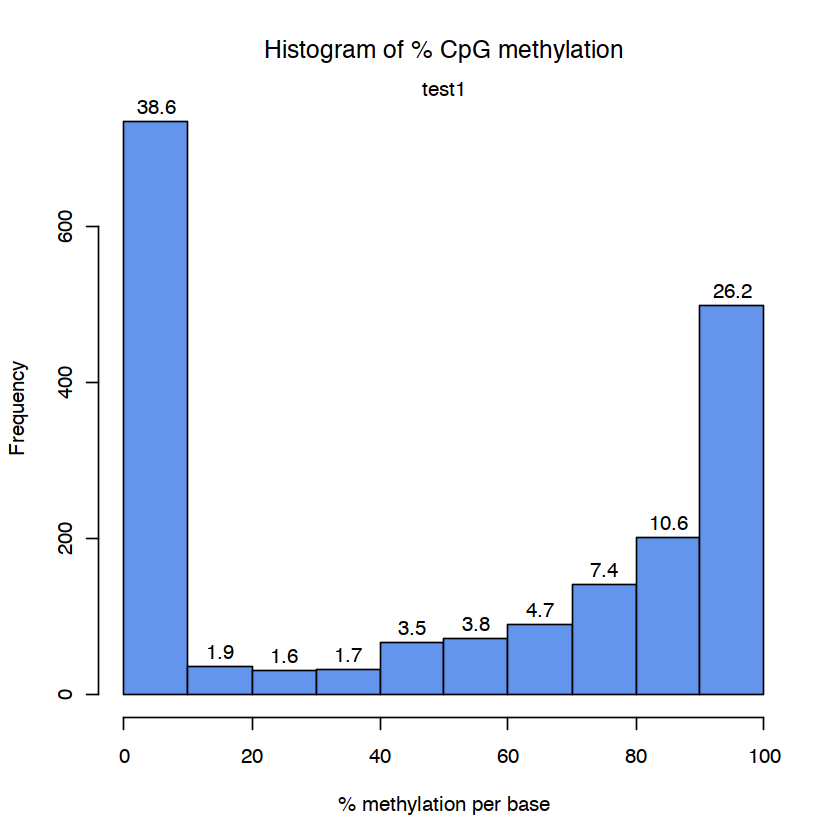

In [11]:
# test2 のデータをチェック
getMethylationStats(myobj[[1]],plot=TRUE,both.strands=FALSE)

In [12]:
# plot=FALSE を指定すると、Summary データを得られます
getMethylationStats(myobj[[2]],plot=FALSE,both.strands=FALSE)

methylation statistics per base
summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   20.00   82.79   63.17   94.74  100.00 
percentiles:
       0%       10%       20%       30%       40%       50%       60%       70% 
  0.00000   0.00000   0.00000  48.38710  70.00000  82.78556  90.00000  93.33333 
      80%       90%       95%       99%     99.5%     99.9%      100% 
 96.42857 100.00000 100.00000 100.00000 100.00000 100.00000 100.00000 



2. カバレッジの確認を行います。デフォルトでは、methlyKit パッケージの場合、最低 10x カバレッジを持つ塩基を解析対象とします。  
異常な高カバレッジを持つ塩基が存在する場合、PCR バイアスである可能性があります。

methylKit パッケージでは、上記のデータを可視化する関数として、`getCoverageStats()` 関数が用意されています。

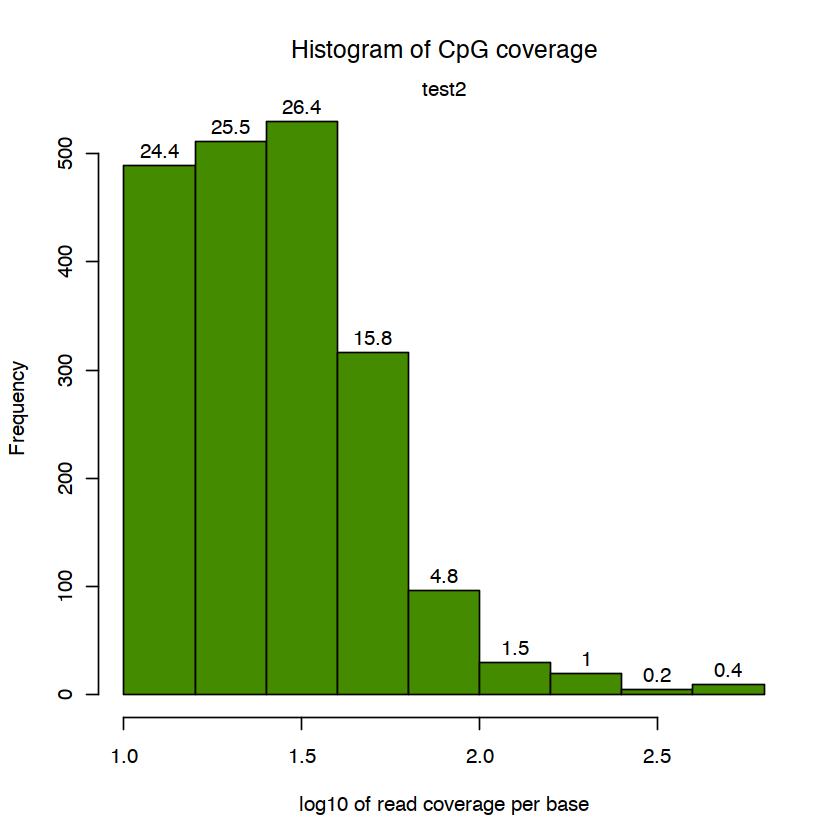

In [13]:
# test2 のデータをチェック
getCoverageStats(myobj[[2]],plot=TRUE,both.strands=FALSE)

In [15]:
# plot=FALSE を指定すると、Summary データを得られます
getCoverageStats(myobj[[2]],plot=FALSE,both.strands=FALSE)

read coverage statistics per base
summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   16.00   26.00   34.45   39.00  630.00 
percentiles:
     0%     10%     20%     30%     40%     50%     60%     70%     80%     90% 
 10.000  11.000  14.000  17.000  20.000  26.000  30.000  36.000  42.000  60.000 
    95%     99%   99.5%   99.9%    100% 
 78.750 195.800 328.300 441.945 630.000 



上述したとおり、カバレッジの高すぎるものや低すぎるものは元データからカットしたほうが、データのノイズをカットでき、後の解析で適切な結果を得られやすくなります。

以下の例では、次の条件でデータをフィルタリングしています。
- 99.9th パーセンタイル（上位 0.1% をカット）
- 10x カバレッジ以上

In [16]:
filtered.myobj=filterByCoverage(myobj,lo.count=10,lo.perc=NULL,
                                      hi.count=NULL,hi.perc=99.9)

In [22]:
# フィルタリングしたデータでは、当たり前だが Max と Mean が低下
getCoverageStats(myobj[[2]],plot=FALSE,both.strands=FALSE)
getCoverageStats(filtered.myobj[[2]],plot=FALSE,both.strands=FALSE)

read coverage statistics per base
summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   16.00   26.00   34.45   39.00  630.00 
percentiles:
     0%     10%     20%     30%     40%     50%     60%     70%     80%     90% 
 10.000  11.000  14.000  17.000  20.000  26.000  30.000  36.000  42.000  60.000 
    95%     99%   99.5%   99.9%    100% 
 78.750 195.800 328.300 441.945 630.000 

read coverage statistics per base
summary:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   16.00   26.00   33.71   39.00  431.00 
percentiles:
     0%     10%     20%     30%     40%     50%     60%     70%     80%     90% 
 10.000  11.000  14.000  17.000  20.000  26.000  30.000  36.000  42.000  59.000 
    95%     99%   99.5%   99.9%    100% 
 77.900 187.000 253.740 428.986 431.000 



### 10.4.3 複数サンプルのリストデータを１つのテーブルにマージ
サンプル間で比較を行いたいので、１つのテーブルにマージして扱いやすい形に変換します。  

methylKit パッケージでは、上記のデータを可視化する関数として、`unite()` 関数が用意されています。

In [23]:
# :: notation を使うことで、明示的に「methylKit パッケージの unite 関数を使いますよ」と示すことができます
# MEMO: unite という関数名が一般的な名前すぎるので、名前が他の関数とかぶるため。
meth=methylKit::unite(myobj, destrand=FALSE)
head(meth)

uniting...



,chr,start,end,strand,coverage1,numCs1,numTs1,coverage2,numCs2,numTs2,coverage3,numCs3,numTs3,coverage4,numCs4,numTs4
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr21,9853296,9853296,+,17,10,7,333,268,65,18,16,2,395,341,54
2,chr21,9853326,9853326,+,17,12,5,329,249,79,16,14,2,379,284,95
3,chr21,9860126,9860126,+,39,38,1,83,78,5,83,83,0,41,40,1
4,chr21,9906604,9906604,+,68,42,26,111,97,14,23,18,5,37,33,4
5,chr21,9906616,9906616,+,68,52,16,111,104,7,23,14,9,37,27,10
6,chr21,9906619,9906619,+,68,59,9,111,109,2,22,18,4,37,29,8


デフォルトでは、`unite()` 関数はすべてのサンプルでカバーされている塩基/領域を抽出し、マージします。  
`min.per.group` という引数があり、少なくとも N つのサンプルで出現する塩基/領域であればマージ後のデータに加えるという条件をつけることができます。

In [24]:
# 少なくとも１つのサンプル/グループで出現する塩基/領域であれば、データに加える
# ただし、両方のグループ(control と test)のいずれかのサンプルで出現する塩基/領域である必要がある
meth.min=unite(myobj,min.per.group=1L)

uniting...



C塩基の箇所が C->T mutation を起こしているかどうかや、２群間で統計的な有意差が見られない塩基かどうかを判断したい。

In [27]:
# methylation(%) マトリクスを取得
pm=percMethylation(meth)
pm[10:20,]

test1,test2,ctrl1,ctrl2
80.952381,96.66667,100.00000,92.30769
57.142857,93.33333,37.83784,42.30769
42.857143,88.33333,41.02564,57.69231
46.153846,81.13208,26.66667,43.47826
21.428571,90.24390,76.00000,90.47619
92.857143,100.00000,93.33333,90.90909
71.428571,82.92683,71.42857,63.63636
28.571429,15.00000,0.00000,0.00000
66.666667,80.48780,26.66667,31.81818
7.142857,41.46341,15.38462,36.36364


In [30]:
# CpG の標準偏差を計算
mds=matrixStats::rowSds(pm)
mds[10:20]

[1]  8.306509 25.175819 21.882619 22.871572 32.779144  3.958199  7.947636
 [8] 13.744201 26.295478 16.446661  7.500000

In [31]:
head(meth[mds>20,])

,chr,start,end,strand,coverage1,numCs1,numTs1,coverage2,numCs2,numTs2,coverage3,numCs3,numTs3,coverage4,numCs4,numTs4
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
11,chr21,9906681,9906681,+,21,12,9,60,56,4,37,14,23,26,11,15
12,chr21,9906694,9906694,+,21,9,12,60,53,7,39,16,23,26,15,11
13,chr21,9906700,9906700,+,13,6,7,53,43,10,30,8,22,23,10,13
14,chr21,9906714,9906714,+,14,3,11,41,37,4,25,19,6,21,19,2
18,chr21,9906873,9906873,+,12,8,4,41,33,8,15,4,11,22,7,15
23,chr21,9927527,9927527,+,17,5,12,40,22,18,32,32,0,14,11,3


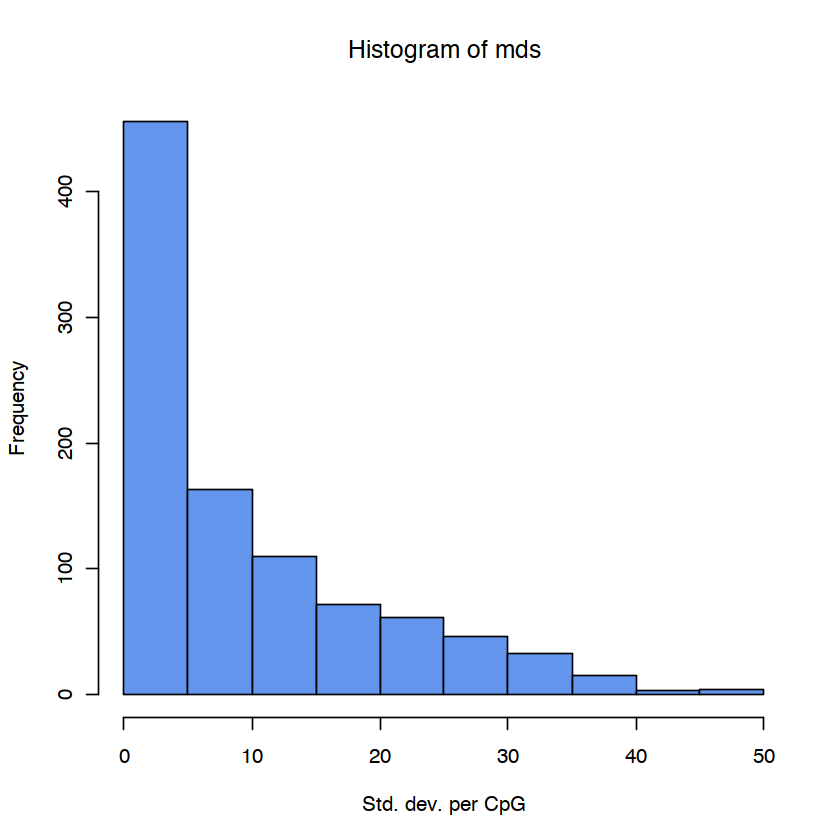

In [32]:
# 標準偏差とそれに対応する塩基の数を可視化
hist(mds,col="cornflowerblue",xlab="Std. dev. per CpG")

C->T mutation の箇所を特定します。該当箇所は元データからカットする必要があります（バイサルファイト処理により塩基の置換が起こった箇所ではないため）。

In [34]:
library(GenomicRanges)

In [35]:
# SNP(サンプル)を取得
mut=GRanges(seqnames=c("chr21","chr21"),
            ranges=IRanges(start=c(9853296, 9853326),
                           end=c( 9853296,9853326)))

In [37]:
# mutation の箇所と overlap しない CpG を抽出
sub.meth=meth[! as(meth,"GRanges") %over% mut,]

In [38]:
# ２箇所が mutation 箇所だった
nrow(meth)
nrow(sub.meth)

[1] 963

[1] 961

### 10.4.5 クラスタリング
似た methlylation の傾向にあるサンプルをクラスタリングします。

ここでは階層的クラスタリングの１つである Ward 法（ウォード法）を利用します。  
サンプル間の「1 - 相関係数」を距離として定義し、クラスタの偏差平方和が最小となるようにクラスタリングを行います。

#### 参考
- [階層クラスタリング - スピアマンの順位相関係数を利用したクラスタリング](https://bi.biopapyrus.jp/rnaseq/analysis/clutering/hclust.html)
- [クラスタリング手法のクラスタリング](https://qiita.com/suecharo/items/20bad5f0bb2079257568#ward-%E6%B3%95%E6%9C%80%E5%B0%8F%E5%88%86%E6%95%A3%E6%B3%95)
- [階層的クラスター分析の「ウォード法（Ward法）」とは？そのクラスタリング・アルゴリズムなど分かりやすくまとめました](https://it-mint.com/2017/09/23/hierarchical-clustering-ward-method-1238.html)


Call:
hclust(d = d, method = HCLUST.METHODS[hclust.method])

Cluster method   : ward.D2 
Distance         : pearson 
Number of objects: 4 


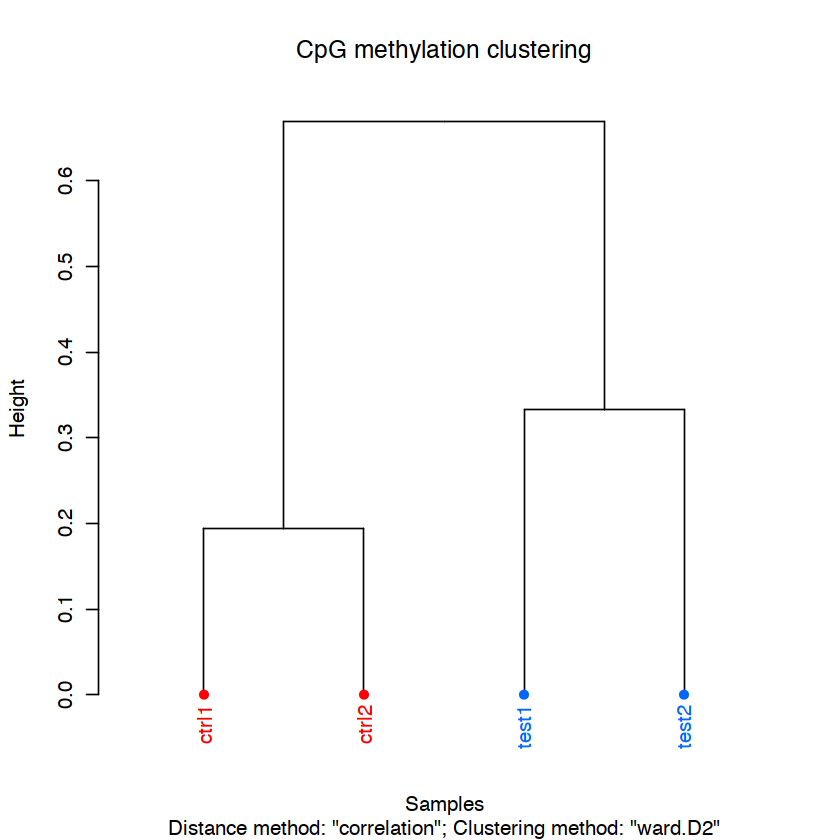

In [40]:
clusterSamples(meth, dist="correlation", method="ward.D2", plot=TRUE)

In [42]:
# グラフなし
hc = clusterSamples(meth, dist="correlation", method="ward.D2", plot=FALSE)
hc


Call:
hclust(d = d, method = HCLUST.METHODS[hclust.method])

Cluster method   : ward.D2 
Distance         : pearson 
Number of objects: 4 


### 10.4.6 主成分分析

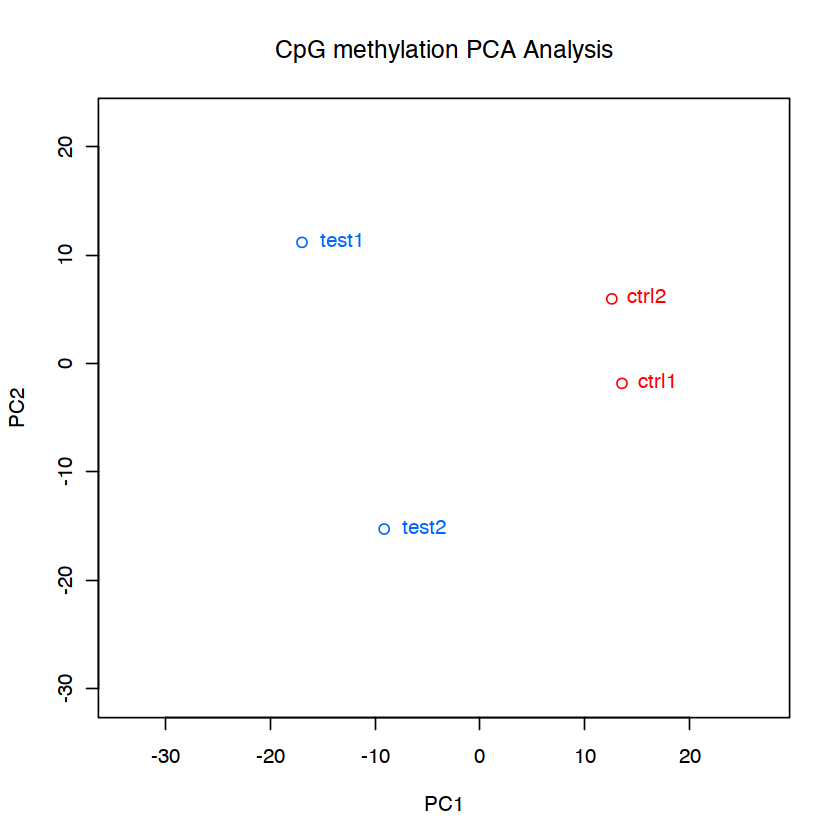

In [43]:
pc=PCASamples(meth,obj.return = TRUE, adj.lim=c(1,1))